===== Univariate Summary =====
       Campaign_ID Platform Ad_Type   Impressions       Clicks  Conversions  \
count         1000     1000    1000   1000.000000  1000.000000  1000.000000   
unique        1000        5       4           NaN          NaN          NaN   
top        CAM0001   Google   Video           NaN          NaN          NaN   
freq             1      204     260           NaN          NaN          NaN   
mean           NaN      NaN     NaN  49739.334000  2505.566000   252.478000   
std            NaN      NaN     NaN  27760.356195  1471.439394   143.528966   
min            NaN      NaN     NaN   1155.000000    14.000000     0.000000   
25%            NaN      NaN     NaN  26166.000000  1243.500000   129.000000   
50%            NaN      NaN     NaN  50327.000000  2517.000000   256.000000   
75%            NaN      NaN     NaN  72328.500000  3833.500000   375.750000   
max            NaN      NaN     NaN  99977.000000  4997.000000   499.000000   

              Spend 

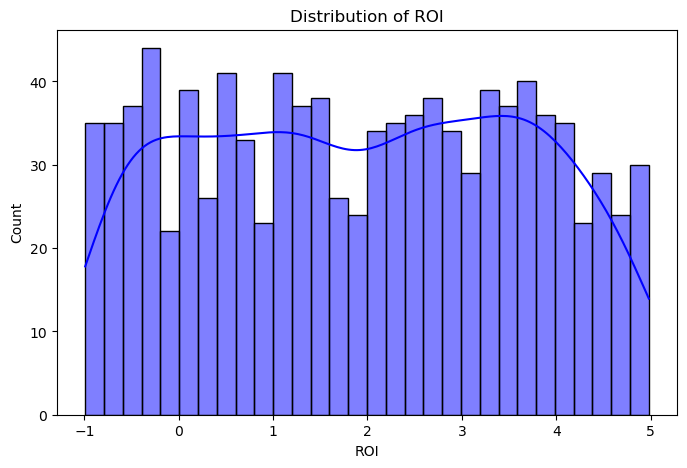


===== Bivariate Summary (ROI_Class vs Features) =====

Group stats for Spend:
           count         mean          std     min      25%       50%  \
ROI_Class                                                               
Low        335.0  5260.349224  2827.350927   67.21  2901.55  5305.260   
Medium     167.0  5031.751796  2846.394167  116.54  2260.04  5414.660   
High       498.0  5067.324317  2806.442822   81.68  2772.27  5107.865   

                75%      max  
ROI_Class                     
Low        7777.885  9985.37  
Medium     7381.790  9994.14  
High       7451.295  9993.08  

Group stats for CTR:
           count      mean       std     min      25%      50%     75%     max
ROI_Class                                                                     
Low        335.0  0.108257  0.056472  0.0103  0.05650  0.11270  0.1592  0.1984
Medium     167.0  0.103033  0.052206  0.0123  0.05815  0.10760  0.1408  0.1984
High       498.0  0.105372  0.055074  0.0104  0.05850  0.10605

C:\Users\Priyadharshini\AppData\Local\Temp\ipykernel_14888\1908656598.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ROI_Class')[col].describe())
C:\Users\Priyadharshini\AppData\Local\Temp\ipykernel_14888\1908656598.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ROI_Class')[col].describe())
C:\Users\Priyadharshini\AppData\Local\Temp\ipykernel_14888\1908656598.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

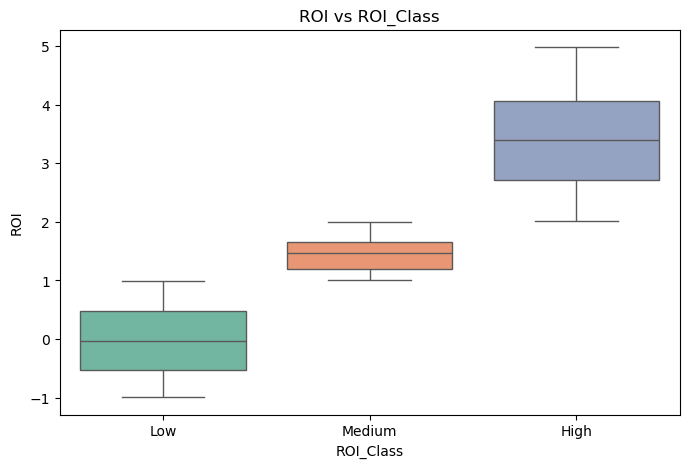

Class distribution (0=Not profitable, 1=Profitable):
ROI_Class
1    665
0    335
Name: count, dtype: int64

Categorical columns: ['Platform', 'Ad_Type']
Numeric columns: ['Impressions', 'Clicks', 'Conversions', 'Spend', 'Revenue', 'CTR', 'ROI']

Top 15 features by ANOVA F-score (preview):
               feature       score
                   ROI 1696.978216
      Platform_Twitter    6.818973
     Platform_LinkedIn    6.078424
           Conversions    2.009837
                 Spend    1.714897
                   CTR    0.850935
       Platform_Google    0.666945
    Platform_Instagram    0.370764
               Revenue    0.307402
Ad_Type_Sponsored Post    0.055318
        Ad_Type_Banner    0.053163
           Impressions    0.043362
      Ad_Type_Carousel    0.029852
         Ad_Type_Video    0.028138
     Platform_Facebook    0.002410

=== Accuracy Leaderboard ===
DecisionTree      Acc: 1.0000  Prec: 1.0000  Rec: 1.0000  F1: 1.0000
RandomForest      Acc: 1.0000  Prec: 1.0000  Rec: 1

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 2) Load Data

df = pd.read_csv("advertising_campaign_performance.csv")

# Check required columns
required = {"Campaign_ID","Platform","Ad_Type","Impressions","Clicks","Conversions","Spend","Revenue","CTR","ROI"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing columns: {missing}")

df['ROI_Class'] = pd.cut(df['ROI'],
                           bins=[-float('inf'), 1, 2, float('inf')],
                           labels=['Low', 'Medium', 'High'])


# Univariate Analysis

print("===== Univariate Summary =====")
print(df.describe(include='all'))   # summary stats for numeric + categorical

# One plot: ROI distribution
plt.figure(figsize=(8,5))
sns.histplot(df['ROI'], bins=30, kde=True, color='blue')
plt.title("Distribution of ROI")
plt.show()

# Bivariate Analysis

print("\n===== Bivariate Summary (ROI_Class vs Features) =====")
for col in ['Spend','CTR','Revenue']:
    print(f"\nGroup stats for {col}:")
    print(df.groupby('ROI_Class')[col].describe())

# One plot: ROI vs ROI_Class
plt.figure(figsize=(8,5))
sns.boxplot(x='ROI_Class', y='ROI', data=df, palette="Set2")
plt.title("ROI vs ROI_Class")
plt.show()


# 3) Target Engineering

df["ROI_Class"] = (df["ROI"] > 1.0).astype(int)
print("Class distribution (0=Not profitable, 1=Profitable):")
print(df["ROI_Class"].value_counts())

if df["ROI_Class"].nunique() < 2:
    raise ValueError("ROI_Class has only one class. Need both 0 and 1 to train a classifier.")


# 4) Basic Cleaning

core_cols = ["Platform","Ad_Type","Impressions","Clicks","Conversions","Spend","Revenue","CTR","ROI","ROI_Class"]
df = df.dropna(subset=core_cols).copy()
df = df.drop(columns=["Campaign_ID"])  # drop ID

X = df.drop(columns=["ROI_Class"])
y = df["ROI_Class"]

categorical_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


# 5) Preprocessing

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="drop"
)


# 6) Feature Selection + SMOTE + Models

k = 10
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "SVM-Linear": SVC(kernel="linear", probability=True),
    "SVM-RBF": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

results = {}

def get_feature_names(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "get_feature_names_out"):
            fn = trans.get_feature_names_out(cols)
        else:
            fn = cols
        names.extend(fn)
    return np.array(names)

# Fit preprocess to extract feature names
_ = preprocess.fit(X_train_raw, y_train)
feature_names = get_feature_names(preprocess)

# Show feature scores
selector_preview = SelectKBest(score_func=f_classif, k="all")
X_train_pre = preprocess.transform(X_train_raw)
selector_preview.fit(X_train_pre, y_train)
scores_df = pd.DataFrame({"feature": feature_names, "score": selector_preview.scores_})
scores_df = scores_df.sort_values("score", ascending=False)
print("\nTop 15 features by ANOVA F-score (preview):")
print(scores_df.head(15).to_string(index=False))

# Train models
for name, clf in models.items():
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("kbest", SelectKBest(score_func=f_classif, k=min(k, len(feature_names)))),
        ("model", clf)
    ])

    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "report": classification_report(y_test, y_pred, zero_division=0),
        "cm": confusion_matrix(y_test, y_pred),
        "pipeline": pipe
    }

# 7) Report

print("\n=== Accuracy Leaderboard ===")
for m, r in sorted(results.items(), key=lambda x: x[1]["accuracy"], reverse=True):
    print(f"{m:16s}  Acc: {r['accuracy']:.4f}  Prec: {r['precision']:.4f}  Rec: {r['recall']:.4f}  F1: {r['f1']:.4f}")

best_model_name = max(results, key=lambda m: results[m]["accuracy"])
best_pipe = results[best_model_name]["pipeline"]
kbest_mask = best_pipe.named_steps["kbest"].get_support()
feat_names_after = get_feature_names(best_pipe.named_steps["preprocess"])
selected_features = feat_names_after[kbest_mask]

print(f"\nBest model: {best_model_name}")
print("Selected features (k-best):")
for f in selected_features:
    print(" -", f)

print("\nConfusion Matrix (best model):")
print(results[best_model_name]["cm"])

print("\nClassification Report (best model):")
print(results[best_model_name]["report"])


In [14]:
# =========================
# Advanced Models: XGBoost & LightGBM
# (works with your current dataset & pipeline style)
# =========================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Try importing advanced models (skip gracefully if missing)
xgb_ok = lgb_ok = True
try:
    from xgboost import XGBClassifier
except Exception as e:
    xgb_ok = False
    print("⚠️ XGBoost not available. Install with: pip install xgboost")
    print("Reason:", e)

try:
    from lightgbm import LGBMClassifier
except Exception as e:
    lgb_ok = False
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")
    print("Reason:", e)

# -------------------------
# Load & prepare data
# -------------------------
df = pd.read_csv("advertising_campaign_performance.csv")

required = {"Campaign_ID","Platform","Ad_Type","Impressions","Clicks","Conversions","Spend","Revenue","CTR","ROI"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing columns: {missing}")

# Binary target: profitable if ROI > 1.0
df["ROI_Class"] = (df["ROI"] > 1.0).astype(int)

# Clean
core_cols = ["Platform","Ad_Type","Impressions","Clicks","Conversions","Spend","Revenue","CTR","ROI","ROI_Class"]
df = df.dropna(subset=core_cols).copy()
df = df.drop(columns=["Campaign_ID"])

X = df.drop(columns=["ROI_Class"])
y = df["ROI_Class"]

categorical_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Class distribution (0=Not profitable, 1=Profitable):")
print(y.value_counts())

# -------------------------
# Preprocess
# -------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="drop"
)

# Split BEFORE SMOTE
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit preprocess to get feature names and set k
preprocess.fit(X_train_raw, y_train)
def get_feature_names(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "get_feature_names_out"):
            names.extend(list(trans.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return np.array(names)

feature_names = get_feature_names(preprocess)
k = min(10, len(feature_names))

# -------------------------
# Define advanced models
# -------------------------
models = {}
if xgb_ok:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"  # fast
    )

if lgb_ok:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        n_jobs=-1
    )

if not models:
    raise RuntimeError("Neither XGBoost nor LightGBM is available. Please install them and rerun.")

# -------------------------
# Train & evaluate (baseline)
# -------------------------
results = {}
for name, clf in models.items():
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("kbest", SelectKBest(score_func=f_classif, k=k)),
        ("model", clf)
    ])
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "report": classification_report(y_test, y_pred, zero_division=0),
        "cm": confusion_matrix(y_test, y_pred),
        "pipeline": pipe
    }

print("\n=== Advanced Models: Baseline Results ===")
for m, r in sorted(results.items(), key=lambda x: x[1]["accuracy"], reverse=True):
    print(f"{m:10s}  Acc: {r['accuracy']:.4f}  Prec: {r['precision']:.4f}  Rec: {r['recall']:.4f}  F1: {r['f1']:.4f}")

best_name = max(results, key=lambda m: results[m]["accuracy"])
print(f"\nBest (baseline): {best_name}")
print("Confusion Matrix:\n", results[best_name]["cm"])
print("\nClassification Report:\n", results[best_name]["report"])

# -------------------------
# Optional: Hyperparameter tuning (GridSearchCV)
# Keeps the same pipeline, just searches model__ params.
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grids = {}
if xgb_ok:
    grids["XGBoost"] = {
        "model__n_estimators": [200, 400],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.03, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0]
    }
if lgb_ok:
    grids["LightGBM"] = {
        "model__n_estimators": [200, 400, 600],
        "model__num_leaves": [31, 63, 127],
        "model__learning_rate": [0.03, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0]
    }

tuned = {}
for name, clf in models.items():
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("kbest", SelectKBest(score_func=f_classif, k=k)),
        ("model", clf)
    ])
    param_grid = grids[name]
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_raw, y_train)
    print(f"\n{name} - Best Params: {grid.best_params_}")
    print(f"{name} - Best CV Score: {grid.best_score_:.4f}")

    # Evaluate tuned model on test set
    y_pred = grid.best_estimator_.predict(X_test_raw)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

    tuned[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "report": classification_report(y_test, y_pred, zero_division=0),
        "cm": confusion_matrix(y_test, y_pred),
        "best_estimator": grid.best_estimator_,
        "best_params": grid.best_params_,
        "best_cv": grid.best_score_
    }

print("\n=== Advanced Models: Tuned Results ===")
for m, r in sorted(tuned.items(), key=lambda x: x[1]["accuracy"], reverse=True):
    print(f"{m:10s}  Test Acc: {r['accuracy']:.4f}  Prec: {r['precision']:.4f}  Rec: {r['recall']:.4f}  F1: {r['f1']:.4f}  (CV: {r['best_cv']:.4f})")

best_tuned_name = max(tuned, key=lambda m: tuned[m]["accuracy"])
print(f"\nBest (tuned): {best_tuned_name}")
print("Best Params:", tuned[best_tuned_name]["best_params"])
print("Confusion Matrix:\n", tuned[best_tuned_name]["cm"])
print("\nClassification Report:\n", tuned[best_tuned_name]["report"])


Class distribution (0=Not profitable, 1=Profitable):
ROI_Class
1    665
0    335
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 532, number of negative: 532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [3]:
!pip install xgboost

In [4]:
!pip install lightgbm

In [12]:
!pip install xgboost lightgbm imbalanced-learn
